## Download Dataset, Packages

Dataset is found [here](https://github.com/karolpiczak/ESC-50#download). 

In [1]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip

--2021-02-18 10:34:36--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2021-02-18 10:34:36--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/master [following]
--2021-02-18 10:34:36--  https://codeload.github.com/karolpiczak/ESC-50/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [       <=>          ] 615.7

In [2]:
!unzip -q /content/master.zip 

In [3]:
!pip install torchaudio==0.7.0

     |████████████████████████████████| 7.6MB 19.3MB/s 


In [4]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os, cv2
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.models as models

import torchaudio
torchaudio.set_audio_backend("sox_io")

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Quick EDA

In [5]:
train_csv = pd.read_csv('/content/ESC-50-master/meta/esc50.csv')
train_csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Number of labels  50
Labels dist


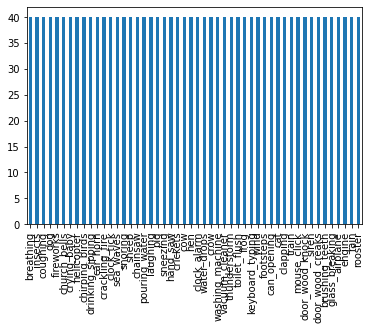

In [16]:
print("Number of labels ", train_csv.category.nunique())
print("Labels dist")
train_csv.category.value_counts().plot(kind='bar')
plt.show()

Number of audio files 2000
Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100
Number of Seconds: 5.0
File1 target name 'cow'
Min of waveform: -23143, Max of waveform: 21415


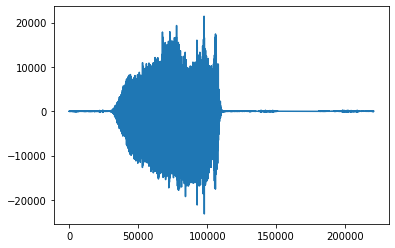

In [17]:
audio_dir = '/content/ESC-50-master/audio/'
print(f"Number of audio files {len(os.listdir(audio_dir))}")
file1 = os.listdir(audio_dir)[500]
file1_info = train_csv[train_csv['filename'] == file1]
filename = audio_dir + file1
waveform, sample_rate = torchaudio.load(filename, normalize=False)

print("Shape of waveform: {}".format(waveform.size())) 
# [0] is number of channels (mono=1, stereo=2),[1] is number of frames i.e len of waveform

print("Sample rate of waveform: {}".format(sample_rate)) 
# frames per second i.e sampling rate, number of samples taken per second

print("Number of Seconds: {}".format(waveform.size()[1]/ sample_rate))
print("File1 target name '{}'".format(file1_info['category'].values[0]))
print("Min of waveform: {}, Max of waveform: {}".format(waveform.min(), waveform.max()))

plt.figure()
plt.plot(waveform.t().numpy())
plt.show()

## Extract Features

## Librosa

In [21]:
import librosa
import librosa.display as LD

Waveform
(110250,)


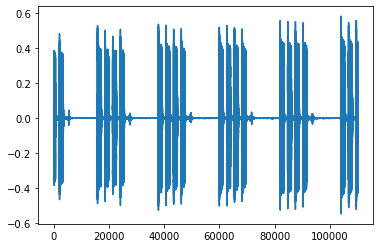

In [45]:
# display waveform(wave) from signal(load audio file, scale)

waveform, sample_rate = librosa.load(filename, duration=5.0)
print("Waveform")
print(waveform.shape)
plt.figure()
plt.plot(waveform)
plt.show()

Mel spectogram
(128, 431)


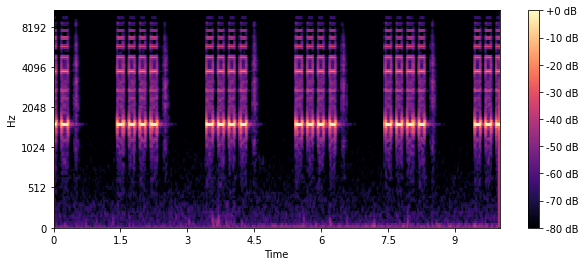

In [46]:
#display mel Spectrogram

waveform, sample_rate = librosa.load(filename, duration=5.0, sr=None)
melspec = librosa.feature.melspectrogram(waveform,sr=sample_rate)
print("Mel spectogram")
print(melspec.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                         y_axis='mel',
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

Mel spectogram
(1025, 216)


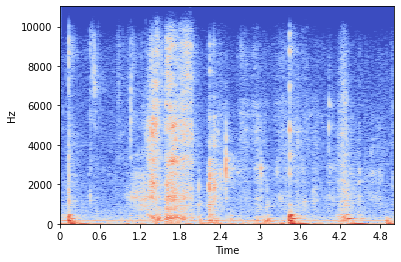

In [51]:
# load, stft, amptodb

file1 = os.listdir(audio_dir)[25]
filename = audio_dir + file1
waveform, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
xs = librosa.stft(waveform)
print("Mel spectogram")
print(xs.shape)
xdb = librosa.amplitude_to_db(abs(xs)) # converted to logarithmic scale
librosa.display.specshow(xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.show()

MFCC
(20, 431)


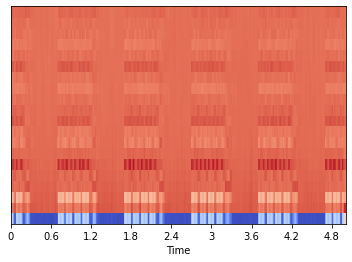

In [47]:
# Mel Frequency Coefficient

mfccs = librosa.feature.mfcc(waveform, sr=sample_rate)
print("MFCC")
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.show()

In [25]:
def spec_to_image(spec, eps=1e-6):
  """
  Scale spectogram to create image
  """
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

def get_melspec(filename, n_mels=128):
  """
  Get melspec, power(amplitude squared) to decibels, check size if smaller than 128 then concanate with zeros.
  """
  waveform, sample_rate = librosa.load(filename, duration=5.0, sr=None)
  melspec = librosa.feature.melspectrogram(waveform, sr=sample_rate, n_fft=2024, hop_length=512, n_mels=n_mels)
  melspec = librosa.power_to_db(melspec)
  # if less than zero concanate them
  if melspec.shape[0] < 128:
      melspec = np.concatenate((melspec, np.zeros((128-melspec.shape[0],n_mels))),axis=0)
  return melspec 

def get_mfcc(filename):  
  """
  Get mfcc
  """
    waveform, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    return mfccsscaled

## Torch Audio

Spectrogram
Shape of spectrogram: torch.Size([1, 201, 1103])


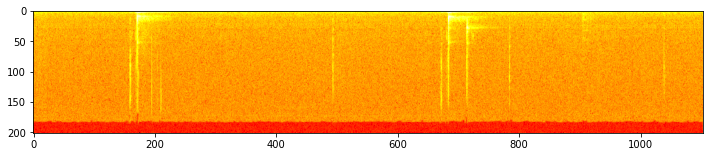

In [55]:
# view spectogram

waveform, sample_rate = torchaudio.load(filename)
specgram = torchaudio.transforms.Spectrogram()(waveform)
print("Spectrogram")
print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure(figsize=(12, 8))
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='hot')
plt.show()

Melspec torch audio
torch.Size([64, 552])
time 0.018419504165649414


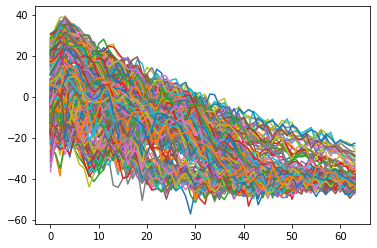

In [29]:
# torch audio melspec

import time
t0 = time.time()
print("Melspec torch audio")
waveform, sample_rate = torchaudio.load(filename)
re_waveform = torchaudio.transforms.Resample(44100, 22050)(waveform)
specgram = torchaudio.transforms.MelSpectrogram(n_mels=64)(re_waveform)
spec_to_db = torchaudio.transforms.AmplitudeToDB()(specgram) 
print(spec_to_db[0].shape)
t1 = time.time()
print(f"time {t1-t0}") 
plt.plot(spec_to_db[0])
plt.show()

## Create/Save Images

melspectrogram features

melspectrogram
(128, 431) 44100
time 0.02007269859313965


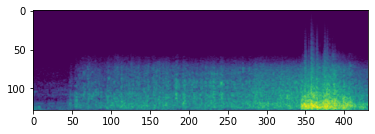

In [59]:
# melspectrogram, power_to_db(to convert to decibals), then as b/w image

import time
t0 = time.time()
file1 = os.listdir(audio_dir)[6]
# file1_info = train_csv[train_csv['filename'] == file1]
filename = audio_dir + file1
spec = get_melspec(filename)
img = spec_to_image(melspec) # melspec to image range values 0-255
# img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img = cv2.flip(img, 0)
img = np.float32(img)/255.0 # normalize for model

t1 = time.time()
print('melspectrogram')
print(img.shape, sample_rate)
print(f"time {t1-t0}") 

# display the image

# img = img.reshape(3, 128, 431)
# img = img.reshape(128, 431, 3)
# plt.imshow((img * 255).astype(np.uint8))
# plt.show()
plt.imshow(img)
plt.show()

In [ ]:
# save melspecs as images to dir

save_dir = '/content/drive/MyDrive/Datasets/env_sound_dataset/'

all_audio_files_paths = []
all_targets = []
all_names = []

for f in os.listdir(audio_dir):
  filename = audio_dir + f
  spec = get_melspec(filename)
  img = spec_to_image(spec)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  img = cv2.flip(img, 0)
  cv2.imwrite(save_dir+f[:-4]+'.jpg', img)
  all_names.append(f[:-4])
  t = train_csv[train_csv['filename'] == f]
  all_targets.append(t.target.values[0])
print(f"Total images saved: {len(os.listdir(save_dir))}")  

# csv containing image_id and labels
data = np.array([all_names, all_targets])
data_csv = pd.DataFrame({'image_id': data[0, :],'targets':data[1,:]})
data_csv.to_csv(save_dir+'meta.csv')

mfcc features

In [ ]:
# save mfcc as images to dir

save_dir = '/content/drive/MyDrive/Datasets/env_dataset_mfcc'

all_audio_files_paths = []
all_targets = []
all_names = []

for f in os.listdir(audio_dir):
  filename = audio_dir + f
  spec = get_mfcc(filename)
  img = spec_to_image(spec)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  img = cv2.flip(img, 0)
  cv2.imwrite(save_dir+f[:-4]+'.jpg', img)
  all_names.append(f[:-4])
  t = train_csv[train_csv['filename'] == f]
  all_targets.append(t.target.values[0])
print(f"Total images saved: {len(os.listdir(save_dir))}")  

# csv containing image_id and labels
data = np.array([all_names, all_targets])
data_csv = pd.DataFrame({'image_id': data[0, :],'targets':data[1,:]})
data_csv.to_csv(save_dir+'meta.csv')

## Training

Load saved images and create train/test

In [38]:
import glob 

all_audio_files_paths = glob.glob('/content/drive/MyDrive/Datasets/env_sound_dataset/*.jpg')
data_csv = pd.read_csv(glob.glob('/content/drive/MyDrive/Datasets/env_sound_dataset/*.csv')[0])
all_targets = []

for img_id in os.listdir('/content/drive/MyDrive/Datasets/env_sound_dataset'):
  t = data_csv.loc[data_csv.image_id == img_id[:-4], 'targets'].values
  all_targets.extend(t)

x_train, x_test, y_train, y_test = train_test_split(all_audio_files_paths, all_targets, test_size=0.2, 
                                                    random_state=2048, shuffle=True)  
print(f"Train Size {len(y_train)}, Test Size {len(y_test)}")

Train Size 1600, Test Size 400


In [39]:
cv2.imread(x_train[0]).shape

(128, 431, 3)

In [43]:
class MakeDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, targets, small_sub=False):

        self.x_data, self.y_data = file_paths, targets
        self.len = len(self.x_data)

        if small_sub:
          self.x_data = self.x_data[0:500]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        filename = self.x_data[idx]
        img = cv2.imread(filename)
        img = np.float32(img)/255.0
        img = torch.from_numpy(img).reshape(3, 128, 431)
        y = torch.tensor(self.y_data[idx])
        return img, y

print("Done")          

Done


In [ ]:
BS = 128

# transform = [transform.transform.ToTensor()]

trainset = MakeDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BS, shuffle=True)

validset = MakeDataset(x_test, y_test)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BS, shuffle=False)

In [ ]:
## eg run
# model = models.resnet18(pretrained=True).cuda(0)
# model.fc = torch.nn.Linear(in_features=512, out_features=50).cuda(0)
# model.fc.requires_grad_(True)
# one_by_one_cnnlayer = torch.nn.Conv2d(1, 3, kernel_size=1, bias=True).cuda(0) # 1 channel to 3 channel
# new_model = torch.nn.Sequential(one_by_one_cnnlayer,model)  
# i = torch.randn(10,1,128,216).cuda(0)
# op = new_model(i)
# op.shape

In [ ]:
%%time

model = models.resnet18(pretrained=True).cuda(0)
model.fc = torch.nn.Linear(in_features=512, out_features=50).cuda(0)
# model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).cuda(0)
model.requires_grad_(True)
# one_by_one_cnnlayer = torch.nn.Conv2d(1, 3, kernel_size=1, bias=True).cuda(0) # 1 channel to 3 channel
# one_by_one_cnnlayer.requires_grad_(True)
# model = torch.nn.Sequential(one_by_one_cnnlayer, model)  

LR = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
cost_function = torch.nn.CrossEntropyLoss()
TRAIN_STEP = len(trainset)/BS
VALID_STEP = len(valid_loader)/BS
EPOCHS = 30 

TRAIN_LOSS = []
VAL_LOSS = []
VAL_ACC = []

for epoch in range(EPOCHS):
  print("Epoch", epoch+1)
  running_loss = 0.0
  model.train()
  for (x, y) in train_loader:
    optimizer.zero_grad()
    x, y = x.cuda(0), y.cuda(0)
    z = model(x)
    loss = cost_function(z, y)
    running_loss+=loss.detach()
    loss.backward()
    optimizer.step()

  train_l = running_loss/TRAIN_STEP
  TRAIN_LOSS.append(train_l.item())
  total = 0
  correct = 0 
  print("Training loss:", train_l.item()) # current step size 390
  running_loss = 0.0
  model.eval()

  for (x,y) in valid_loader:
    x, y = x.cuda(0), y.cuda(0)
    z = model(x)
    loss = cost_function(z, y)
    running_loss+=loss.detach()
    _, yhat = torch.max(z,1)
    total += y.size(0)
    correct += (yhat == y).sum().item()

  valid_l = running_loss/VALID_STEP
  valid_a = 100 * correct / total
  print("Valid loss:", valid_l.item()) # current step size 78
  VAL_LOSS.append(valid_l.item())
  print('VAL_Accuracy: %d %%' % valid_a)
  VAL_ACC.append(valid_a)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch 1
Training loss: 4.2634687423706055
Valid loss: 517.9124755859375
VAL_Accuracy: 3 %
Epoch 2
Training loss: 3.9823720455169678
Valid loss: 505.07867431640625
VAL_Accuracy: 3 %
Epoch 3
Training loss: 3.7377583980560303
Valid loss: 478.3966979980469
VAL_Accuracy: 7 %
Epoch 4
Training loss: 3.5151562690734863
Valid loss: 447.86126708984375
VAL_Accuracy: 13 %
Epoch 5
Training loss: 3.3028059005737305
Valid loss: 428.35491943359375
VAL_Accuracy: 17 %
Epoch 6
Training loss: 3.106036901473999
Valid loss: 411.8966369628906
VAL_Accuracy: 20 %
Epoch 7
Training loss: 2.9296815395355225
Valid loss: 397.0880432128906
VAL_Accuracy: 25 %
Epoch 8
Training loss: 2.7648184299468994
Valid loss: 383.63421630859375
VAL_Accuracy: 29 %
Epoch 9
Training loss: 2.6071531772613525
Valid loss: 371.3914489746094
VAL_Accuracy: 33 %
Epoch 10
Training loss: 2.4572291374206543
Valid loss: 359.19549560546875
VAL_Accuracy: 36 %
Epoch 11
Training loss: 2.3216662406921387
Valid loss: 348.7666015625
VAL_Accuracy: 40 